In [1]:
import torch
from torch import nn
from torch.optim import Adam 
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is:", device)

Device is: cuda


## Load Dataset

In [20]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
])

In [21]:
train_dataset = datasets.MNIST(root="./data", download=True, train=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", download=True, train=False, transform=transform)

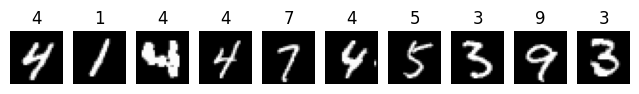

In [22]:
# Displaying random samples
fig, axis = plt.subplots(1, 10, figsize=(8, 1))

for ax in axis:
    ind = np.random.randint(len(train_dataset))
    ax.imshow(train_dataset.data[ind], cmap="gray")
    ax.set_title(train_dataset.targets[ind].item())
    ax.axis(False)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

## Model Architecture

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (input_dim//8) * (input_dim//8), hidden_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * (input_dim//8) * (input_dim//8)),
            nn.ReLU(),
            nn.Unflatten(1, (64, input_dim//8, input_dim//8)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(mu.device)
        return mu + std*eps

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar    

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
model = VAE(32, 15, 128)
t = torch.randn(1, 1, 32, 32)
print(t.shape)
x, y, z = model(t)

print(f'The model has {count_parameters(model):,} trainable parameters')
x.shape, y.shape, z.shape

torch.Size([1, 1, 32, 32])
The model has 197,983 trainable parameters


(torch.Size([1, 1, 32, 32]), torch.Size([1, 15]), torch.Size([1, 15]))

## Training

In [10]:
def loss_function(recon_x, x, mu, logvar):
    loss_recon = nn.functional.mse_loss(recon_x, x, reduction="sum")
    loss_KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss_vae = loss_recon + loss_KL
    return loss_vae

In [37]:
def train_per_epoch():
    model.train()
    
    train_losses = []
    for batch, _ in train_loader:
        
        x = batch.to(device)
        optim.zero_grad()
        
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optim.step()
        
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
        
    return train_loss

def validate():
    model.eval()
    
    val_losses = []
    with torch.no_grad():
        for batch, _ in test_loader:
            x = batch.to(device)
            
            recon_x, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar)
            val_losses.append(loss.item())
    
    val_loss = np.mean(val_losses)
    return val_loss

def train(first_epoch, num_epochs):
    train_losses, val_losses = [], []
    
    for epoch in range(first_epoch, first_epoch + num_epochs):
        
        train_loss = train_per_epoch()
        val_loss = validate()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'[{epoch:03d}] train loss: {train_loss:04f}  '
              f'val loss: {val_loss:04f}')
        
        
        # visualize random sample result
        idx = np.random.randint(0, 64)
        mean = 0.1307
        std = 0.3081

        sample_batch, _ = next(iter(test_loader))
        recon_batch, _, _ = model(sample_batch.cuda())
        recon_batch = recon_batch.cpu().detach().numpy()

#         gt = (sample_batch.numpy()[idx, 0] * 255).astype(np.uint8)
#         rc = (recon_batch[idx, 0] * 255).astype(np.uint8)
        
        gt = sample_batch.cpu().numpy()[idx, 0] * std + mean
        rc = recon_batch[idx, 0] * std + mean
        gt = (gt * 255).astype(np.uint8)
        rc = (rc * 255).astype(np.uint8)


        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Ground Truth')
        plt.imshow(gt, cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title('Reconstructed')
        plt.imshow(rc, cmap="gray")
        plt.savefig(f"results/res{epoch+1}.png")
        plt.close('all')

    return train_losses, val_losses 

In [46]:
model = VAE(input_dim=32, hidden_dim=128, latent_dim=15).to(device)
optim = Adam(model.parameters(), lr=1e-3)
first_epoch = 0
num_epochs = 20
train_losses, val_losses = train(first_epoch, num_epochs)

[000] train loss: 35616.474424  val loss: 30794.332131
[001] train loss: 30167.981780  val loss: 30186.395912
[002] train loss: 29787.512826  val loss: 29969.146677
[003] train loss: 29611.089298  val loss: 29799.318055
[004] train loss: 29494.812813  val loss: 29730.381873
[005] train loss: 29410.040251  val loss: 29652.483218
[006] train loss: 29351.279453  val loss: 29617.051795
[007] train loss: 29296.518064  val loss: 29588.947160
[008] train loss: 29253.726035  val loss: 29520.255928
[009] train loss: 29215.358862  val loss: 29519.647386
[010] train loss: 29186.079897  val loss: 29449.704276
[011] train loss: 29155.196188  val loss: 29454.771677
[012] train loss: 29127.793494  val loss: 29417.857385
[013] train loss: 29106.832023  val loss: 29411.870559
[014] train loss: 29082.361209  val loss: 29389.875317
[015] train loss: 29062.907434  val loss: 29358.560447
[016] train loss: 29043.795062  val loss: 29340.919580
[017] train loss: 29029.075459  val loss: 29338.091691
[018] trai

## Generate new samples

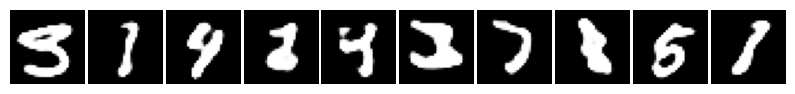

In [49]:
import matplotlib.gridspec as gridspec
import os

z = torch.randn(10, 15).to(device)
model.eval()
samples = model.decoder(z).data.cpu().numpy()

save_file = f'results/vae_generation.jpg'

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(32,32), cmap='Greys_r')
    plt.savefig(save_file)